# Topic Modeling with Latent Dirichlet Allocation (LDA) and MALLET

The following notebook walks you through doing LDA topic modeling in Python using the Gensim package MALLET wrapper. We then use the pyldavis package to create an interactive visualization that can be saved as an html file and can therefore be embeded in a website or simply opened in your browser. 

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (RED)](https://kb.iu.edu/d/apum). You will also need to have access to RED through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](https://github.com/cyberdh/Text-Analysis/blob/master/Python/Py_notebooks/textPrep-Py.ipynb) before you proceed further. The textPrepPy notebook provides information and resources on how to get a Carbonate account, how to set up RED, and how to get started using the Jupyter Notebook on RED.   

### Loading Packages
As mentioned above, we will be using the gensim and pyldavis packages. In addition we will also be using a few other packages that help us do things like read through directories of files, make dataframes, or use natural language processing. Below is a list and a brief description of each:

- **re:** Provides regular expression matching operations similar to those found in Perl.
- **json:** Allows for handling of data in JSON format.
- **sys:** Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- **os:** Provides a portable way of using operating system dependent functionality.
- **string:** Contains a number of functions to process standard Python strings.
- **csv:** Implements classes to read and write tabular data in CSV format.
- **nltk:** A leading platform for building Python programs to work with human language data.
- **glob:** Finds all the pathnames matching a specified pattern according to the rules used by the Unix shell.
- **numpy:** a general-purpose array-processing package designed to efficiently manipulate large multi-dimensional arrays of arbitrary records without sacrificing too much speed for small multi-dimensional arrays. 
- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- **pprint:** Provides a capability to “pretty-print” arbitrary Python data structures in a form which can be used as input to the interpreter.
- **gzip:** Provides a simple interface to compress and decompress files
- **gensim:** Python library for topic modelling, document indexing and similarity retrieval with large corpora.
- **spacy:** A library for advanced Natural Language Processing in Python and Cython.
- **pyldavis:** Python library for interactive topic model visualization.
- **matplotlib:**  Produces publication quality 2D graphics for interactive graphing, scientific publishing, user interface development and web application servers targeting multiple user interfaces and hardcopy output formats.
- **logging:** Defines functions and classes which implement a flexible event logging system for applications and libraries.
- **warnings:** Allows for the manipulation of warning messages in Python.

In [1]:
import re
import json
import sys
import os
from os.path import join, isfile, splitext
import string
import csv
import nltk
from nltk.corpus import stopwords
import glob
import numpy as np
import pandas as pd
from pprint import pprint
import gzip

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Import warning
import logging
import warnings


The code in the cell below points to a module specificaly for use with the Python Jupyter Notebooks created by Cyberinfrastructure for Digital Humanities. It allows for the use of the different pakcages in our notebooks and their subsequent data sets.

#### NOTE: This cell is only for use with Research Desktop. You will get an error if you try to run this cell on your personal device!!

In [2]:
sys.path.insert(0,"/N/soft/rhel7/anaconda/environments/DigHumWkshp/lib/python3.6/site-packages")
os.environ["NLTK_DATA"] = "/N/soft/rhel7/anaconda/environments/DigHumWkshp/nltk_data"

This will give more details regarding error messages and will also ignore deprecation and user warnings. All the deprecation and user warnings in this code are not concerning and will not break the code or cause errors in the results.

In [3]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)

### Getting your data

#### File paths
Here we are saving as variables different file paths that we need in our code. 

First we us the 'os' package above to find our 'HOME' directory using the 'environ' function. This will work for any operating system, so if you decide to try this out on your personal computer instead of ReD, the 'homePath' variable will still be the path to your 'home' directory, so no changes are needed.

Next, we combine the 'homePath' file path with the folder names that lead to where our data is stored. Note that we do not use any file names yet, just the path to the folder. This is because we may want to read in all the files in the directory, or just one. There are options below for doing both. We save the path as a variable named dataHome.

Now we add the 'homePath' file path to other folder names that lead to a folder where we will want to save any output generated by this code. We again will change the file names in the appropriate cells down below. We save this file path as the variable 'dataResults'.

Lastly, since we are using MALLET to do our LDA, you need to [download](http://mallet.cs.umass.edu/download.php) the MALLET zipfile, unzip it and provide the path to the extracted folder. We recommend saving the extracted folder in your 'Carbonate' directory which is also your "home" directory. This way you will not need to adjust anything in the last line as it should point to exactly what we need to run MALLET later on. We save this file path as the variable 'malletPath'. 

In [4]:
homePath = os.environ["HOME"]
dataHome = os.path.join(homePath, "IntroTopicModeling", "data")
dataResults = os.path.join(homePath, "IntroTopicModeling", "Results")
malletPath = os.path.join(homePath, "mallet-2.0.8", "bin", "mallet") # update this path

### Set needed variables
This is where you will make some decisions about your data and set the necessary variables.

First, we need to determine what file type our data is saved as. You can find this by the file extension at the end of your files name. Right now we can only read in plain text files which end in '.txt' (minus the quotes), comma separated values files which in '.csv', and JSON files which end in '.json'. So where it says 'fileType =' inside the double quotes you need to put either ".txt", ".csv", or ".json" depending on what your data file type is.

The 'docLevel' variable is only for file types of '.txt' so if you have a '.csv' or '.json' then don't worry about this one. If your data is in '.txt' format, then you need to determine if you want to separate your corpus by line or by document. If you want to separate by document, then set docLevel equal to **True**. If you want to separate a line at a time and have the line be it's own entity or 'document' then set docLevel equal to **False**. If you are running this on only one document, then setting docLevel equal to **False** is recommended.

Lastly, customStop is for if you have a .txt file that conatins additional stopwords that you would like to read in and have added to the existing stopwords list. **NOTE: Your custom stopwords file needs to have one word per line as it is read in a line at a time and the full contents of the line is read in and added to the existing stopwords list.** If you have a list of your own then set customStop equal to **True**. If you do not have your own custom stopwords list then set customStop equal to **False**.

The docs and tweets variables do not need to have anything done as they are just empty lists that will be added to later in the code.

In [5]:
fileType = ".txt"
docLevel = True
customStop = True
docs = []
tweets = []

### Stopwords
Here we save the nltk stopwords list as the variable 'stopWords' (minus the quotes). If you need a different language, simply change 'english' (keep the quotes) to the anglicized name of the language you wish to use (e.g. 'spanish' instead of 'espanol' or 'german' instead of 'deutsch'). If you wish to add additional words to the stopWords variable, add the word in quotes to the list in stopWords.extend(['the', 'words', 'you', 'want', 'to', 'add']).

If you need to see the list of available languages in nltk simply remove the '#' from in front of the last line and run the cell. A list of available languages will print out.

In [6]:
# **** Problem with variable naming*****
# NLTK Stop words
stopWords = []
stopWords.extend(stopwords.words('english'))

stopWords.extend(['would', 'said', 'says', 'also', 'come', 'good', 'lord'])

#print(" ".join(stopwords.fileids()))

#### Add own stopword list

Here is where your own stopwords list is added if you selected "True" in "customStop" above. Here you will need to change the folder names and file name to match your folders and file. Remember to put each folder name in quotes and in the correct order always putting the file name including the file extension (.txt) last.

In [7]:
if customStop is True:
    stopWordsFilepath = os.path.join(homePath, "IntroTopicModeling", "data", "earlyModernStopword.txt")

    with open(stopWordsFilepath, "r",encoding = 'utf-8') as stopfile:
        stopWordsCustom = [x.strip() for x in stopfile.readlines()]

    stopWords.extend(stopWordsCustom)

### Reading in .txt files
The code below reads in text files. It can do this in two ways. We can read in an entire directory, or we can read in a single file. Remember, LDA generally works best on larger datasets, so if you are uisng a single file it should be a large file. In order to choose between an entire directory or a single file, look at the line of code that starts "for path in glob.glob" (minus the quotes). Towards the end of the line where there is something in quotes that ends in .txt is where you switch between the entire directory or a single file. To read in the entire directory simply put "\*.txt" (this time with the quotes) and this will read all files that end in .txt. To read in a single file replace the "\*" with the file name of the file you are interested in like "myDataSet.txt". 

The below code also lets you choose between reading your data in a file at a time or line by line. You can make this choice whether you are reading in an entire directory or a single file. However, your research and data will determine whether line by line or file by file is best. In order to choose which one you need the part of the code you need to change is where it says "with open(textFilepath, "r") as f:" (minus the quotes). The part following this is where the change is made. To read in the data by file in the folder make sure the lines that say "for line in f:" and then "docs.append(f.readline())" have a "#" in front of them as this comments them out and tells Python to ignore these lines. The line we want Python to read in order to read the data in by file is "docs.append(f.read().splitlines())" (again, minus the quotes). Now to read in the data a line at a time and group the data by line instead of by file simply remove the "#" from in front of the "for line in f:" and the "docs.append(f.readline())" and put a "#" in front of "docs.append(f.read().splitlines())". This will now consider each line, regardless of which file it came from, as it's own data element. 

In [8]:
if fileType == ".txt":
    paths = glob.glob(os.path.join(dataHome, "Shakespeare", "*" + fileType))
    for path in paths:
        with open(path, "r", encoding = 'utf-8') as file:
             # skip hidden file
            if path.startswith('.'):
                continue
            if docLevel is True:
                docs.append(file.read().strip('\n').splitlines())
            else:
                for line in file:
                    stripLine = line.strip()
                    if len(stripLine) == 0:
                        continue
                    docs.append(stripLine.split())

### Reading in .csv files

The code below reads in an entire directory of .csv files and saves them all to a dataframe using the Pandas package. Then we choose the column in the dataframe we need and add each row in that column to a list. It is important that the .csv files contain similar data and identical column headers or you will get errors when the files are concatinated together. The last line is where you will name the column you wish to convert to a list. In between the square brackets you can either put the column header name with quotes around the name, or you can put the column number counting from left to right and starting with 0 instead of 1. If you wish to read in a single .csv file then replace the part in the first line of code that has "\*.csv" with "filename.csv" and this will read in that .csv file from the directory.

In [9]:
if fileType == ".csv":
    all_files = glob.glob(os.path.join(dataHome, "Twitter", "*" + fileType))     
    df_all = (pd.read_csv(f) for f in all_files)
    cc_df   = pd.concat(df_all, ignore_index=True)
    cc_df = pd.DataFrame(cc_df, dtype = 'str')
    tweets = cc_df['text'].values.tolist()

### Reading in JSON files

The code below reads in an entire directory of JSON files and saves them all to a dataframe using the Pandas package. Then we choose the column in the dataframe we need and add each row in that column to a list. It is important that the JSON files contain similar data and identical keys or you will get errors when the files are concatinated together. The last line is where you will name the column you wish to convert to a list. In between the square brackets you can either put the column header name with quotes around the name, or you can put the column number counting from left to right and starting with 0 instead of 1. If you wish to read in a single .json file then replace the part in the line of code that has "\*.json" with "filename.json" and this will read in that .json file from the directory.

In [10]:
if fileType == ".json":
    for filename in glob.glob(os.path.join(dataHome, "Twitter", "*" + fileType)):
        with open(filename) as jsonData:
            for line in jsonData:
                tweets.append(json.loads(line))
    df = pd.DataFrame(content)
    tweets = df['text'].tolist()            
    print(len(df))

### Data cleaning

Now we need to change our variable containing our data (either docs or tweets from above) to the variable "data" since this is the variable used going forward. So if your data came from a text file, the first line should be data = docs, if it came from a .csv or .json file it should be data = tweets.

The next two lines are generally only needed if your data is tweets or some other social media or blog where urls and new line characters need to be removed. To do this simply remove the "#" from in front of "data =" in the next two lines of code. If your data is good old fashioned text from a corpus then leave these lines commented out.

The last line simply prints out the first chunk of data in our collection. This can be a whole text file or single line depending on your previous choices.

In [11]:
if len(docs) == 0:
    data = tweets
else:
    data = docs

if len(tweets) >= 1:
# Remove Urls
    data = [re.sub(r'http\S+', '', sent) for sent in data]
# Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

pprint(data[:10])

[[' Noble patricians, patrons of my right,',
  ' Defend the justice of my cause with arms.',
  ' And countrymen, my loving followers,',
  ' Plead my successive title with your swords.',
  ' I am his firstborn son that was the last',
  ' That wore the imperial diadem of Rome.',
  " Then let my father's honours live in me,",
  ' Nor wrong mine age with this indignity.',
  '',
  ' Romans, friends, followers, favourers of my right,',
  " If ever Bassianus, Caesar's son,",
  ' Were gracious in the eyes of royal Rome,',
  ' Keep, then, this passage to the Capitol,',
  ' And suffer not dishonour to approach',
  ' The imperial seat, to virtue consecrate,',
  ' To justice, continence, and nobility;',
  ' But let desert in pure election shine,',
  ' And, Romans, fight for freedom in your choice.',
  '',
  '',
  ' Princes that strive by factions and by friends',
  ' Ambitiously for rule and empery,',
  ' Know that the people of Rome, for whom we stand',
  ' A special party, have by common voice,'

### Tokenizing

This block of code separates each chunk of text in a list of individual words. In the process it also lower cases all the words and removes punctuation. If you wish to keep the punctuation change "deacc = True" to "deacc = False".

In [12]:
def sentToWords(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

dataWords = list(sentToWords(data))

print(dataWords[:10])

[['noble', 'patricians', 'patrons', 'of', 'my', 'right', 'defend', 'the', 'justice', 'of', 'my', 'cause', 'with', 'arms', 'and', 'countrymen', 'my', 'loving', 'followers', 'plead', 'my', 'successive', 'title', 'with', 'your', 'swords', 'am', 'his', 'firstborn', 'son', 'that', 'was', 'the', 'last', 'that', 'wore', 'the', 'imperial', 'diadem', 'of', 'rome', 'then', 'let', 'my', 'father', 'honours', 'live', 'in', 'me', 'nor', 'wrong', 'mine', 'age', 'with', 'this', 'indignity', 'romans', 'friends', 'followers', 'favourers', 'of', 'my', 'right', 'if', 'ever', 'bassianus', 'caesar', 'son', 'were', 'gracious', 'in', 'the', 'eyes', 'of', 'royal', 'rome', 'keep', 'then', 'this', 'passage', 'to', 'the', 'capitol', 'and', 'suffer', 'not', 'dishonour', 'to', 'approach', 'the', 'imperial', 'seat', 'to', 'virtue', 'consecrate', 'to', 'justice', 'continence', 'and', 'nobility', 'but', 'let', 'desert', 'in', 'pure', 'election', 'shine', 'and', 'romans', 'fight', 'for', 'freedom', 'in', 'your', 'choic

### Find Bigrams and Trigrams

This code will most likely not need to be adjusted. It simply looks for bigrams and trigrams in your dataset that occur frequently and then connect them with an underscore so the LDA algorithm will later consider them as one word. This is a good idea for items like 'new york' or 'new zealand' or 'Ho Chi Minh'. If we do not combine these frequently occuring phrases then 'new' and 'york' will be considered independently and give us less accurate results. 

Right now we have a min_count of 5 and a threshold of 100. The min_count is simply the minimum number of times the bigram or trigram needs to occur in order to be combined with an underscore. The threshold is a score that the bigram or trigram needs to exceed in order to be combined with an underscore. The score is determined by doing a count of wordA and a count of wordB then a count of the bigram of wordA_wordB and a count of the vocabulary of the entire dataset and then the min_count we set earlier. Then the min_count is subtracted from the bigram and that result is multiplied by the vocabulary count. This number is then divided by the product of the wordA and wordB counts. The formula looks like this: (bigram_count - min_count)\*vocab_count/(wordA_count \* wordB_count). If the resulting score is above your threshold then the ngram is considered important enough to combine with an underscore and will be viewed as one word for the LDA scoring later. Therefore, if you increase the threshold, you will get fewer bigrams and trigrams. For trigrams you simply divide by the product of all three words (wordA_count \* wordB_count \* wordC_count).

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(dataWords, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[dataWords], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigramMod = gensim.models.phrases.Phraser(bigram)
trigramMod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigramMod[bigramMod[dataWords[0]]])

['noble', 'patricians', 'patrons', 'of', 'my', 'right', 'defend', 'the', 'justice', 'of', 'my', 'cause', 'with', 'arms', 'and', 'countrymen', 'my', 'loving', 'followers', 'plead', 'my', 'successive', 'title', 'with', 'your', 'swords', 'am', 'his', 'firstborn', 'son', 'that', 'was', 'the', 'last', 'that', 'wore', 'the', 'imperial', 'diadem', 'of', 'rome', 'then', 'let', 'my', 'father', 'honours', 'live', 'in', 'me', 'nor', 'wrong', 'mine', 'age', 'with', 'this', 'indignity', 'romans', 'friends', 'followers', 'favourers', 'of', 'my', 'right', 'if', 'ever', 'bassianus', 'caesar', 'son', 'were', 'gracious', 'in', 'the', 'eyes', 'of', 'royal', 'rome', 'keep', 'then', 'this', 'passage', 'to', 'the', 'capitol', 'and', 'suffer', 'not', 'dishonour', 'to', 'approach', 'the', 'imperial', 'seat', 'to', 'virtue', 'consecrate', 'to', 'justice', 'continence', 'and', 'nobility', 'but', 'let', 'desert', 'in', 'pure', 'election', 'shine', 'and', 'romans', 'fight', 'for', 'freedom', 'in', 'your', 'choice

### Some cleaning functions

Below are functions we are creating that perform certain tasks. First we are creating a function to remove the stopwords that are in our stopword list we created previously. Then we create functions to apply our bigram and trigram code from above. Lastly we create a lemmatization function. What is lemmatization? Well, in our case we are using it to tag words as nouns, adjectives, verbs, or adverbs. A lemmatizer can also conjugate verbs and decline nouns into their root or infinitive/nominative form. This can be useful in topic modeling as the terms run, running, and ran will be changed to 'run' so you know if the idea of 'running' in general is a part of a topic.  

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def removeStopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopWords] for doc in texts]

def makeBigrams(texts):
    return [bigramMod[doc] for doc in texts]

def makeTrigrams(texts):
    return [trigramMod[bigramMod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    textsOut = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        textsOut.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return textsOut

Now we apply the cleaning functions. There is really only one part where you will need to make changes and that is in the line nlp = spacy.load('en', disable=\['parser', 'ner'\]). This line of code determines what language you want to use for lemmatization and also disables the parser and named entity recognizer (ner). The languages available for spacy include the list below and to download them you need to open your temrinal and type in the following:

##### NOTE: The following are for Research Desktop use. If using on your own machine remove --user from the end. Also, if using an Anaconda installed version of Python 3 on your own machine do not add the 3 to python, should simply be "python -m spacy download en" (minus the quotes).

- **English:** python3 -m spacy download en --user
- **Spanish:** python3 -m spacy download es --user
- **German:** python3 -m spacy download de --user
- **French:** python3 -m spacy download fr --user
- **Italian:** python3 -m spacy download it --user
- **Portuguese:** python3 -m spacy download pt --user
- **Dutch:** python3 -m spacy download nl --user
- **Multi-Language:** python3 -m spacy download xx --user

To choose a language simply type the two letter code you just used to download the language in between the single quotes where it says 'en'. So for Spanish it would be 'es' (with the quotes) and for German 'de' and so on.

If you wish for your words to be parsed simply remover 'parser' (with the quotes) from the "disable=" bracket. Same for ner. If you wish to use both the parser and ner then just remove the ", disable=\['parser', 'ner'\]" entirely (including the preceding comma).

In [15]:
# Remove Stop Words
dataWordsNostops = removeStopwords(dataWords)

# Form Bigrams
dataWordsBigrams = makeBigrams(dataWordsNostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
dataLemmatized = lemmatization(dataWordsBigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(dataLemmatized[:1])

[['noble', 'patrician', 'patron', 'right', 'defend', 'justice', 'because', 'arm', 'countryman', 'love', 'follower', 'plead', 'successive', 'title', 'sword', 'firstborn', 'son', 'wear', 'imperial', 'diadem', 'rome', 'let', 'father', 'honour', 'live', 'wrong', 'age', 'indignity', 'roman', 'friend', 'follower', 'favourer', 'right', 'bassianus', 'caesar', 'son', 'gracious', 'eye', 'royal', 'rome', 'passage', 'capitol', 'suffer', 'dishonour', 'approach', 'imperial', 'seat', 'virtue', 'consecrate', 'justice', 'continence', 'nobility', 'let', 'desert', 'pure', 'election', 'shine', 'roman', 'fight', 'freedom', 'choice', 'prince', 'strive', 'faction', 'friend', 'ambitiously', 'rule', 'empery', 'know', 'people', 'rome', 'stand', 'special', 'party', 'common', 'voice', 'election', 'roman', 'empery', 'choose', 'andronicus', 'surnam', 'pius', 'great', 'desert', 'rome', 'noble', 'man', 'braver', 'warrior', 'live', 'day', 'city', 'wall', 'senate', 'accit', 'home', 'weary', 'war', 'barbarous', 'goth', 

### Create the Dictionary and Corpus needed for Topic Modeling

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them. 

Gensim creates a unique id for each word in the document. The produced corpus shown below the block of code is a mapping of (word_id, word_frequency).

For example, (0, 1) below implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

In [16]:
# Create Dictionary
id2word = corpora.Dictionary(dataLemmatized)

# Create Corpus
texts = dataLemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1])

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [17]:
id2word[0]

'aaron'

Or, you can see a human-readable form of the corpus itself.

In [18]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('aaron', 25),
  ('ab', 1),
  ('abandon', 1),
  ('abate', 1),
  ('abhorred', 1),
  ('abide', 1),
  ('abjectly', 1),
  ('able', 1),
  ('abominable', 2),
  ('abroad', 2),
  ('abuse', 1),
  ('accept', 1),
  ('accit', 1),
  ('accompany', 3),
  ('accomplish', 1),
  ('account', 1),
  ('accurse', 4),
  ('accursed', 2),
  ('accuse', 1),
  ('acheron', 1),
  ('achieve', 3),
  ('acquaint', 1),
  ('act', 1),
  ('acteon', 1),
  ('action', 2),
  ('add', 1),
  ('adder', 1),
  ('adjudge', 1),
  ('admit', 2),
  ('ado', 2),
  ('adopt', 1),
  ('adore', 3),
  ('adorn', 1),
  ('adulteress', 1),
  ('advance', 5),
  ('advanced', 2),
  ('advantage', 1),
  ('advent', 1),
  ('advice', 6),
  ('advise', 3),
  ('aemilius', 4),
  ('aenea', 1),
  ('affect', 1),
  ('affected', 1),
  ('afflict', 3),
  ('afford', 3),
  ('affy', 1),
  ('afoot', 1),
  ('age', 10),
  ('aged', 5),
  ('ago', 1),
  ('agree', 3),
  ('aid', 1),
  ('aim', 2),
  ('air', 2),
  ('ajax', 1),
  ('ala', 3),
  ('alarbus', 2),
  ('alas', 1),
  ('alci

### USING MALLET

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. As longs as you have [downloaded](http://mallet.cs.umass.edu/download.php) the MALLET zipfile, extracted it and provided the path to the extracted mallet folder in the file paths cell towards the top, then you should be good. 

In the line of code, the only parts you will possibly change is "num_topics=20" and "iterations=1000". These numbers determine the number of topic bins you want to use and the number of times you want to iterate through and run the LDA algorithm over your data. Adjustments should be made according to your specific data set.

In [19]:
ldamallet = gensim.models.wrappers.LdaMallet(malletPath, corpus=corpus, num_topics=20, id2word=id2word, iterations = 1000)

Now we display the "Top Ten" topics and the coherence score of the MALLET topics. The results show the topic number, the ten highest weighted (or important) keywords, and the weight score of those words. Finally, you get the coherence score.

In [20]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherenceModelLdamallet = CoherenceModel(model=ldamallet, texts=dataLemmatized, dictionary=id2word, coherence='c_v')
coherenceLdamallet = coherenceModelLdamallet.get_coherence()
print('\nCoherence Score: ', coherenceLdamallet)

[(15,
  [('night', 0.01779233424803045),
   ('speak', 0.01203859431707533),
   ('nature', 0.011950075241214482),
   ('father', 0.011241922634327698),
   ('time', 0.011064884482606),
   ('hold', 0.010710808179162609),
   ('fear', 0.00982561742055413),
   ('act', 0.009471541117110738),
   ('soul', 0.00938302204124989),
   ('dead', 0.00805523590333717)]),
 (13,
  [('cassio', 0.02008102871234807),
   ('duke', 0.015677294345605074),
   ('angelo', 0.013739651224238154),
   ('husband', 0.011625858728201514),
   ('claudio', 0.011449709353531795),
   ('soul', 0.011273559978862075),
   ('brother', 0.011097410604192354),
   ('death', 0.010921261229522635),
   ('die', 0.010921261229522635),
   ('wife', 0.010568962480183195)]),
 (1,
  [('hector', 0.031160311603116032),
   ('prince', 0.022960229602296024),
   ('troilus', 0.018040180401804017),
   ('achille', 0.016195161951619515),
   ('love', 0.014350143501435014),
   ('hero', 0.014145141451414513),
   ('troy', 0.013325133251332513),
   ('ajax', 0.0

### FIND OPTIMAL NUMBER OF TOPICS

Next we will try and find the optimal number of topics. To do this we build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value. We do this by creating the function "compute_coherence_values" (minus the quotes). You will most likley not want to make changes to the function. Any possible changes will come in the next block.

In [21]:
def computeCoherenceValues(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    modelList : List of LDA topic models
    coherenceValues : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherenceValues = []
    modelList = []
    for numTopics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(malletPath, corpus=corpus, num_topics=numTopics, id2word=id2word)
        modelList.append(model)
        coherenceModel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherenceValues.append(coherenceModel.get_coherence())

    return modelList, coherenceValues

The compute_coherence_values()trains multiple LDA models and provides the models and their corresponding coherence scores. Right now we have it set to start with two topics and increase the number of topics by six every time and stopping at forty topics. If we wanted to start at 1 and go up by two topics each time and stop at 30 topics as the max we would change the start, limit, and step numbers to start=1, limit=30, step=2. This is the only part of the code you may want to adjust depending on your needs.

In [22]:
# Can take a long time to run.
modelList, coherenceValues = computeCoherenceValues(dictionary=id2word, corpus=corpus, texts=dataLemmatized, start=2, limit=40, step=6)

Now we want to visualize the coherence scores for each number of topics to help us decide what number we should use goig forward. Here we need to make sure the limit, start, and step are the same as what we have in the block above so that we can accurately see the coherence scores for each topic.

Choosing a ‘k’ (number of topics) that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics. If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large. To choose the number of topics that might be best do not just use the highest coherence score. There are other factors that need to be considered. If the coherence score just seems to keep climbing higher and higher along with the number of topics, it might be best to find the number where it appears to stop and flatten out a bit before continuing to ascend. You do not want to run the risk of having too many or too few topics.

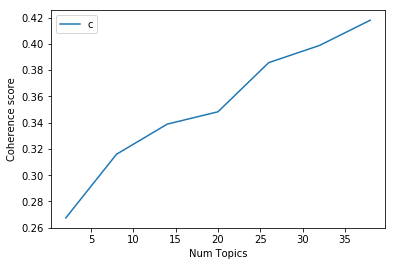

In [23]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherenceValues)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherenceValues"), loc='best')
plt.show()

Now that we have a visual, it may help to go back and look at the actuall numbers. The code below lists the coherence score for each number of topics we have selected. 

In [24]:
# Print the coherence scores
for m, cv in zip(x, coherenceValues):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2675
Num Topics = 8  has Coherence Value of 0.316
Num Topics = 14  has Coherence Value of 0.3389
Num Topics = 20  has Coherence Value of 0.3483
Num Topics = 26  has Coherence Value of 0.3857
Num Topics = 32  has Coherence Value of 0.3988
Num Topics = 38  has Coherence Value of 0.418


Now we choose how many topics we want to work with going forward. To do this we count Pythonically (so starting with 0) and in the first line we choose where the number of topics we want falls in the list from the previous block. So if I wish to keep using twenty topics, in the first line of code I would put "optimal_model = model_list[3]" (minus the quotes) which says I want to use the third item in the list called "model_list" which in this case is using twenty topics. If I wanted twenty-six topics I would change the [3] to a [4]. Pick whichever number of topics you think provides the best results for your data. We have it set to twenty (or number [3] in the list).

The second line of code says we want to see the topics and the keywords associated with them as well as the weightage of each word.

The final line of code says that we only want to see the top ten keywords based on their wightage.

In [25]:
# Select the model and print the topics
optimalModel = modelList[3]
modelTopics = optimalModel.show_topics(formatted=False)
pprint(optimalModel.print_topics(num_words=10))

[(0,
  '0.068*"king" + 0.024*"france" + 0.022*"majesty" + 0.020*"england" + '
  '0.013*"noble" + 0.013*"french" + 0.011*"grace" + 0.011*"land" + '
  '0.011*"fair" + 0.010*"prince"'),
 (1,
  '0.023*"great" + 0.019*"war" + 0.015*"sword" + 0.013*"peace" + 0.013*"god" + '
  '0.013*"blood" + 0.012*"soldier" + 0.012*"fight" + 0.012*"bear" + '
  '0.009*"speak"'),
 (2,
  '0.057*"love" + 0.028*"cassio" + 0.015*"valentine" + 0.015*"moor" + '
  '0.014*"sylvia" + 0.013*"proteus" + 0.012*"soul" + 0.012*"honest" + '
  '0.012*"lose" + 0.011*"matter"'),
 (3,
  '0.018*"night" + 0.018*"lie" + 0.017*"love" + 0.017*"death" + 0.017*"eye" + '
  '0.016*"day" + 0.014*"speak" + 0.012*"man" + 0.012*"dead" + 0.012*"make"'),
 (4,
  '0.108*"caesar" + 0.042*"antony" + 0.040*"brutus" + 0.020*"cassius" + '
  '0.019*"noble" + 0.018*"rome" + 0.016*"man" + 0.013*"hear" + 0.013*"roman" + '
  '0.012*"egypt"'),
 (5,
  '0.029*"love" + 0.017*"kate" + 0.016*"master" + 0.014*"sweet" + 0.014*"play" '
  '+ 0.012*"moon" + 0.010*"

### Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about. To find that, we find the topic number that has the highest percentage contribution in that document. The format_topics_sentences() function below aggregates this information in a presentable table.

The table created gives the filename , topic number of the most dominant topic for that file, percent contribution of that topic to that document, the keywords of the topic, and the beginning text of the document.

The only part of this you will need to change is the file path where the .csv file output of this table will be saved. This can be found towards the end of this block of code where it says *df_dominant_topic.to_csv('/path/to/where/you/want/file/saved.csv')*.

In [26]:
def formatTopicsSentences(ldamodel=ldamallet, corpus=corpus, texts=data):
    # Init output
    
    sentTopicsDf = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topicNum, propTopic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topicNum)
                topicKeywords = ", ".join([word for word, prop in wp])
                sentTopicsDf = sentTopicsDf.append(pd.Series([int(topicNum), round(propTopic,4), topicKeywords]), ignore_index=True)
            else:
                break
    sentTopicsDf.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    if docLevel is True:
        txtPaths = pd.Series(os.path.basename(pathName) for pathName in paths)

        textPath = pd.Series(txtPaths)
        contents = pd.Series(texts)
        sentTopicsDf = pd.concat([textPath, sentTopicsDf, contents], axis=1)
        return(sentTopicsDf)
    else:
        contents = pd.Series(texts)
        sentTopicsDf = pd.concat([sentTopicsDf, contents], axis=1)
        return(sentTopicsDf)


dfTopicSentsKeywords = formatTopicsSentences(ldamodel=optimalModel, corpus=corpus, texts=data)

# Format
dfDominantTopic = dfTopicSentsKeywords.reset_index(drop=True)
if docLevel is True:
    dfDominantTopic.columns = ['Filename', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
else:
    dfDominantTopic.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
dfDominantTopic.to_csv(os.path.join(dataResults, 'domTopicsHamlet.csv'))
# Show
dfDominantTopic

,Filename,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,1591TitusAndronicus.txt,18.0,0.2964,"son, brother, make, father, hand, tear, heart,...","[ Noble patricians, patrons of my right,, Def..."
1,1605TimonOfAthens.txt,17.0,0.3019,"man, fool, prithee, nature, heart, make, frien...","[ Good day, sir., I am glad you're well., , ..."
2,1599KingHenry5.txt,0.0,0.2161,"king, france, majesty, england, noble, french,...","[ O, for a muse of fire that would ascend, Th..."
3,1590TamingOfTheShrew.txt,5.0,0.2588,"love, kate, master, sweet, play, moon, lion, h...","[ I'll feeze you, in faith., A pair of stocks..."
4,1597KingHenry4_2.txt,9.0,0.1853,"man, prince, time, master, jew, faith, bardolp...","[ Open your ears, for which of you will stop, ..."
5,1601TwelfthNight.txt,15.0,0.2854,"love, lady, fool, fair, wit, sweet, man, make,...","[ If music be the food of love, play on., Giv..."
6,1591KingHenry6_3.txt,16.0,0.3061,"king, york, henry, duke, edward, warwick, deat...","[ I wonder how the King escaped our hands., , ..."
7,1597MerryWivesOfWindsor.txt,13.0,0.4238,"master, woman, wife, page, man, pray, chain, m...","[ Sir Hugh, persuade me not. I will make a, S..."
8,1606Macbeth.txt,3.0,0.2025,"night, lie, love, death, eye, day, speak, man,...","[ When shall we three meet again?, In thunder..."
9,1610Cymbeline.txt,11.0,0.2080,"make, great, speak, honour, time, woman, life,...",[ You do not meet a man but frowns. Our bloods...


### Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. The table created gives the file that is most representative the topic, the topic number, percent contribution of that topic to that document, the keywords of the topic, and the beginning text of the document.

The only part of this you will need to change is the file path where the .csv file output of this table will be saved. This can be found towards the end of this block of code where it says *sent_topics_sorteddf_mallet.to_csv('/path/to/where/you/want/file/saved.csv')*.

In [27]:
# Group top 5 sentences under each topic
sentTopicsSorteddfMallet = pd.DataFrame()

sentTopicsOutdfGrpd = dfTopicSentsKeywords.groupby('Dominant_Topic')

for i, grp in sentTopicsOutdfGrpd:
    sentTopicsSorteddfMallet = pd.concat([sentTopicsSorteddfMallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sentTopicsSorteddfMallet.reset_index(drop=True, inplace=True)

# Format
if docLevel is True:
    sentTopicsSorteddfMallet.columns = ['Filename','Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
else:
    sentTopicsSorteddfMallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
    
sentTopicsSorteddfMallet.to_csv(os.path.join(dataResults,'domArticleTopicHamlet.csv'))

# Show
sentTopicsSorteddfMallet

,Filename,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1599KingHenry5.txt,0.0,0.2161,"king, france, majesty, england, noble, french,...","[ O, for a muse of fire that would ascend, Th..."
1,1603Othello.txt,2.0,0.2362,"love, cassio, valentine, moor, sylvia, proteus...","[ Tush, never tell me! I take it much unkindly..."
2,1595RomeoAndJuliet.txt,3.0,0.3436,"night, lie, love, death, eye, day, speak, man,...","[ Two households, both alike in dignity, (In ..."
3,1599JuliusCaesar.txt,4.0,0.2714,"caesar, antony, brutus, cassius, noble, rome, ...","[ Hence! Home, you idle creatures, get you hom..."
4,1595MidsummerNightsDream.txt,5.0,0.2821,"love, kate, master, sweet, play, moon, lion, h...","[ Now, fair Hippolyta, our nuptial hour, Draw..."
5,1608Coriolanus.txt,6.0,0.2296,"rome, people, mother, hamlet, noble, martius, ...","[ Before we proceed any further, hear me, spe..."
6,1603MeasureForMeasure.txt,7.0,0.2784,"brother, duke, die, marry, claudio, man, speak...","[ Escalus., My lord., , Of government the pr..."
7,1600TroilusAndCressida.txt,8.0,0.2667,"hector, romeo, troilus, achille, sweet, love, ...",[ In Troy there lies the scene. From isles of ...
8,1596KingHenry4_1.txt,9.0,0.2388,"man, prince, time, master, jew, faith, bardolp...","[ So shaken as we are, so wan with care,, Fin..."
9,1594ComedyOfErrors.txt,10.0,0.3767,"bring, house, hear, daughter, bear, wife, husb...","[ Proceed, Solinus, to procure my fall,, And ..."


### Topic distribution across documents

Next we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table displays that information. 

This table tells the topic number, the topic keywords, the number of documents that had this topic as its dominant topic, and what percent of the total number of documents had this topic as the dominant topic.

The only part of this you will need to change is the file path where the .csv file output of this table will be saved. This can be found towards the end of this block of code where it says *df_dominant_topics.to_csv('/path/to/where/you/want/file/saved.csv')*.

In [28]:
# Number of Documents for Each Topic
topicCounts = dfTopicSentsKeywords.groupby(['Dominant_Topic','Topic_Keywords']).size().to_frame('Num_Documents').reset_index()

# Percentage of Documents for Each Topic
topicContribution = round(topicCounts['Num_Documents']/topicCounts['Num_Documents'].sum(), 4)

# Concatenate Column wise
dfDominantTopics = pd.concat([topicCounts, topicContribution], axis=1)

# Change Column names
dfDominantTopics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']
dfDominantTopics.to_csv(os.path.join(dataResults, 'domTopicCountHamlet.csv'))
# Show
dfDominantTopics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"king, france, majesty, england, noble, french,...",2,0.0556
1,2.0,"love, cassio, valentine, moor, sylvia, proteus...",1,0.0278
2,3.0,"night, lie, love, death, eye, day, speak, man,...",4,0.1111
3,4.0,"caesar, antony, brutus, cassius, noble, rome, ...",2,0.0556
4,5.0,"love, kate, master, sweet, play, moon, lion, h...",2,0.0556
5,6.0,"rome, people, mother, hamlet, noble, martius, ...",2,0.0556
6,7.0,"brother, duke, die, marry, claudio, man, speak...",2,0.0556
7,8.0,"hector, romeo, troilus, achille, sweet, love, ...",1,0.0278
8,9.0,"man, prince, time, master, jew, faith, bardolp...",3,0.0833
9,10.0,"bring, house, hear, daughter, bear, wife, husb...",1,0.0278


### Distribution of each topic across each document

This code creates a table that shows each document as well as the percentage of each topic within that document.

There are two lines where changes will need to be made. In the 'sorted_df = doc_topics_df.sort_values(['topic_3','Filenames'], ascending = False)' you will need to change the 'topic_3' to match whatever topic you wish to have the table orderd by. This will allow you to see which documents in descending order have the highest percentage of your topic of interest. The syntax for the topic will always be 'topic_x' as it is going by the column name.

The second part of the code where you will need to make changes is 'sorted_df.to_csv('/N/u/klosteda/Carbonate/Output/doc_topicsSTNG.csv')'. Here you will need to change the filepath to match where you want a .csv of the resulting dataframe to be saved.

In [29]:
if docLevel is True:
    docTopics = []
    for i in range(len(texts)):
        docTopics.append(optimalModel[corpus[i]])


    topicSeriesDf = pd.DataFrame([[y[1] for y in  x] for x in docTopics])


    txtPaths = pd.Series(os.path.basename(pathName) for pathName in paths)

    textPath = pd.Series(txtPaths)
    contents = pd.Series(texts)
    docTopicDis = pd.concat([textPath, topicSeriesDf], axis=1)

    docTopicsDf = docTopicDis.reset_index(drop = True)
    # get length of df's columns
    numCols = len(list(docTopicsDf))

    # generate range of ints for suffixes
    # with length exactly half that of num_cols;
    # if num_cols is even, truncate concatenated list later
    # to get to original list length
    rng = range(0, (numCols) + 1)

    newCols = ['Filenames'] + ['topic_' + str(i) for i in rng]

    # ensure the length of the new columns list is equal to the length of df's columns
    docTopicsDf.columns = newCols[:numCols]

    sortedDf = docTopicsDf.sort_values(['topic_9','Filenames'], ascending = False)
    sortedDf.to_csv(os.path.join(dataResults, 'docTopicsHamlet.csv'))
    sortedDf

### Plot a stacked bar graph

This stacked bar graph shows the distribution of topics within a document. There are a few places where changes might need to be made. 

1. In the colors variable you may wish to change the color from "Vega20" to a different color scheme. Some options can be found [here](https://matplotlib.org/users/colormaps.html).

2. The very next line which reads 'sorted_df_sh = sorted_df[:10]' you may want to change the number '10' depending on how many documents you wish to see. Right now we are diplaying the top 10, but you may only want 5 or 20. Adjust this number accordingly.

3. Where it says 'ax = sorted_df_sh.plot(kind='barh', stacked = True, figsize = (60,70), colormap = colors)' you may want to change the figsize =(60,70). The first number is the width and the second number is the height. Adjust according to your needs.

4. The filepath in the last line will need to be changed to the location you would like a .png image of the bar graph saved.

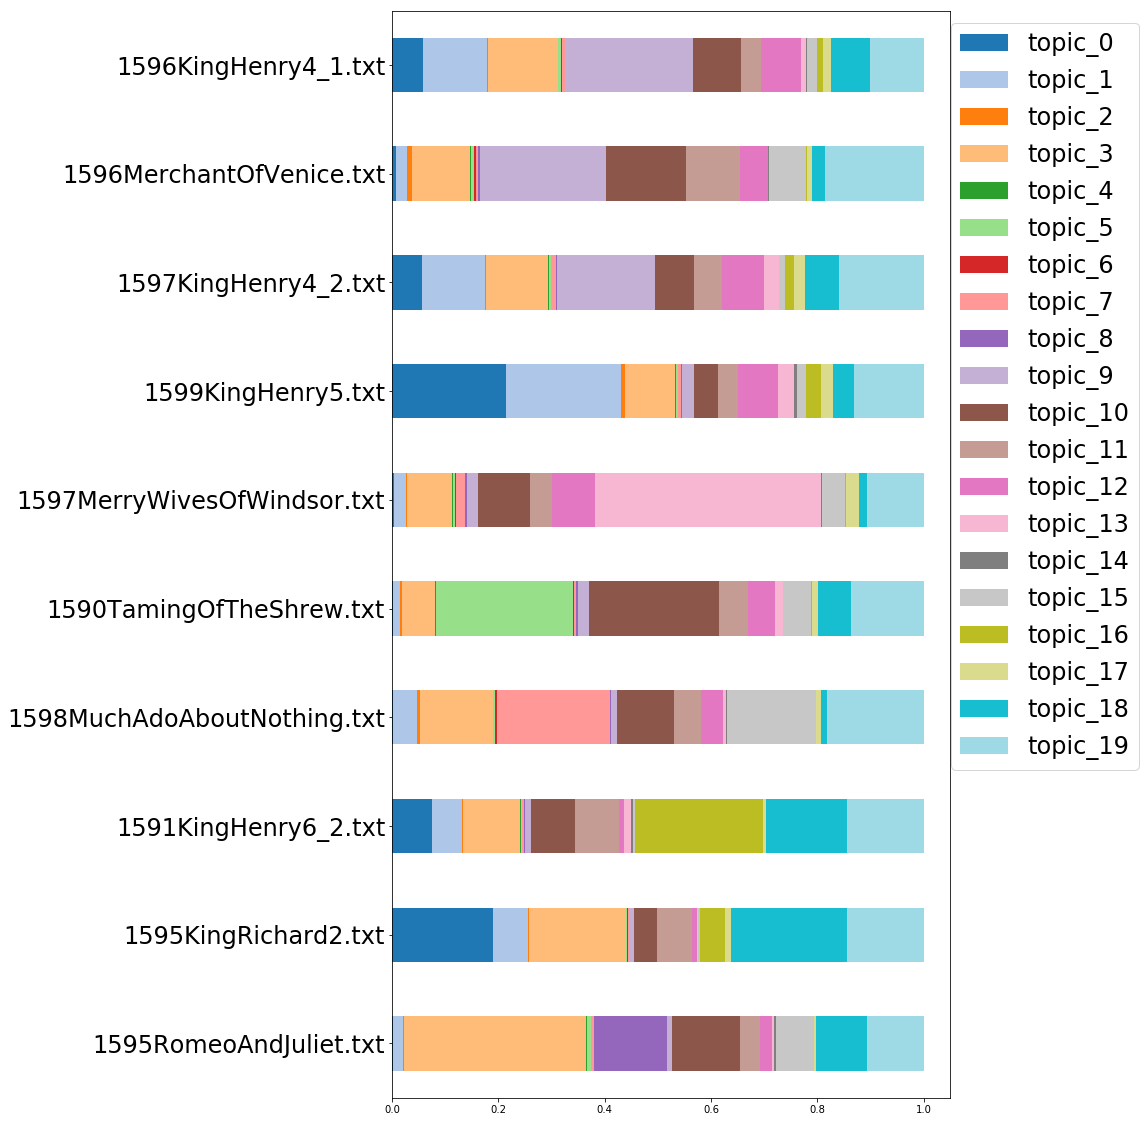

In [30]:
if docLevel is True:
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors

    colors = plt.cm.get_cmap("Vega20")
    sortedDfSh = sortedDf[:10]
    sortedDfSh = sortedDfSh.iloc[::-1]
    ax = sortedDfSh.plot(kind='barh', figsize = (10,20), stacked = True, colormap = colors)
    ax.set_yticklabels(sortedDfSh['Filenames'], rotation=0)
    ax.tick_params(axis = 'y', which = 'major',labelsize = 24)
    lgd = ax.legend(bbox_to_anchor = (1.01,.5,.35,.5), fontsize = 24)
    ax.figure.savefig(os.path.join(dataResults, 'barGraphHamlet.png'), dpi = 300, bbox_inches='tight')

### Making pyLDAvis work with MALLET
##### The code below was adapted from [http://jeriwieringa.com/2018/07/17/pyLDAviz-and-Mallet/#topic=0&lambda=1&term=](http://jeriwieringa.com/2018/07/17/pyLDAviz-and-Mallet/#topic=0&lambda=1&term=) and was last accessed on 01/23/2019.

There should be no need to change any of the code that follows below until the last cell.

The first step is to extract the data from the MALLET statefile and into a pandas dataframe.

In [31]:
statefile = optimalModel.fstate()

def extractParams(statefile):
    """Extract the alpha and beta values from the statefile.

    Args:
        statefile (str): Path to statefile produced by MALLET.
    Returns:
        tuple: alpha (list), beta    
    """
    with gzip.open(statefile, 'r') as state:
        params = [x.decode('utf8').strip() for x in state.readlines()[1:3]]
    return (list(params[0].split(":")[1].split(" ")), float(params[1].split(":")[1]))


def stateToDf(statefile):
    """Transform state file into pandas dataframe.
    The MALLET statefile is tab-separated, and the first two rows contain the alpha and beta hypterparamters.
    
    Args:
        statefile (str): Path to statefile produced by MALLET.
    Returns:
        datframe: topic assignment for each token in each document of the model
    """
    return pd.read_csv(statefile,
                       compression='gzip',
                       sep=' ',
                       skiprows=[1,2]
                       )

params = extractParams(statefile)

alpha = [float(x) for x in params[0][1:]]
beta = params[1]
print("{}, {}".format(alpha, beta))

df = stateToDf(statefile)

[2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5], 0.01


Here we set the type for the entire column "type" to string. This is because nan is used in Pandas to indicate missing integer values, Pandas assumes it is an integer, rather than a string. So we change it to a string.

In [32]:
df['type'] = df.type.astype(str)

The first bit of data to gather is the length of the documents. To do this, we group the data by the document id and count the tokens in the doc. This data is sorted by the document id, so it is in the correct order for the visualization preprocessing.

In [33]:
# Get document lengths from statefile
docs = df.groupby('#doc')['type'].count().reset_index(name ='doc_length')

The second bit of data is the vocabulary and frequencies. Here we use pandas to generate a new frame with the counts for each word. We then sort this dataframe so that it is alphabetical by type, a step we will repeat in creating the topic-term matrix.

In [34]:
# Get vocab and term frequencies from statefile
vocab = df['type'].value_counts().reset_index()
vocab.columns = ['type', 'term_freq']
vocab = vocab.sort_values(by='type', ascending=True)

The third step is to create the matrix files. Here is where things get a bit tricky, as there is the adding of smoothing values and normalizing the data so that each row sums to 1. To do the normalizing, we use sklearn because these are large matrices that require a more optimized function than dividing by the sum of the row with pandas.

In [35]:
# Topic-term matrix from state file
# https://ldavis.cpsievert.me/reviews/reviews.html

import sklearn.preprocessing

def pivotAndSmooth(df, smoothValue, rowsVariable, colsVariable, valuesVariable):
    """
    Turns the pandas dataframe into a data matrix.
    Args:
        df (dataframe): aggregated dataframe 
        smooth_value (float): value to add to the matrix to account for the priors
        rows_variable (str): name of dataframe column to use as the rows in the matrix
        cols_variable (str): name of dataframe column to use as the columns in the matrix
        values_variable(str): name of the dataframe column to use as the values in the matrix
    Returns:
        dataframe: pandas matrix that has been normalized on the rows.
    """
    matrix = df.pivot(index=rowsVariable, columns=colsVariable, values=valuesVariable).fillna(value=0)
    matrix = matrix.values + smoothValue
    
    normed = sklearn.preprocessing.normalize(matrix, norm='l1', axis=1)
    
    return pd.DataFrame(normed)

Now, we need to aggregate the data from the statefile dataframe to get the number of topic assignments for word in the documents. We aggregate by topic and word, count the number of times each word is assigned to each topic, and then sort the resulting dataframe alphabetically by word, so that it matches the order of the vocabulary frame.

Then we do this again, but focused on the documents and topics.

In [36]:
phiDf = df.groupby(['topic', 'type'])['type'].count().reset_index(name ='token_count')
phiDf = phiDf.sort_values(by='type', ascending=True)

phi = pivotAndSmooth(phiDf, beta, 'topic', 'type', 'token_count')

thetaDf = df.groupby(['#doc', 'topic'])['topic'].count().reset_index(name ='topic_count')

theta = pivotAndSmooth(thetaDf, alpha , '#doc', 'topic', 'topic_count')

Now that we have all of the data in place, we can queue that data up and pass it to the visualization library. Then we plot the pyLDAvis graph. Here is where you will want to make a change, which is the filepath in second to last line. Change the filepath to the location where you want to save the .html file. This file can be opened in a web browser simply by double clicking on the file. The file can also be used to embed the graph in a webpage.

In [37]:
dataMallet = {'topic_term_dists': phi, 
        'doc_topic_dists': theta,
        'doc_lengths': list(docs['doc_length']),
        'vocab': list(vocab['type']),
        'term_frequency': list(vocab['term_freq'])
       }

visData = pyLDAvis.prepare(**dataMallet, sort_topics = False)
pyLDAvis.save_html(visData, os.path.join(dataResults, 'ldaVisMalletHamlet.html'))
pyLDAvis.display(visData)


## VOILA!!

Ackowledgements: This algorithm was adapted from the blog "Machine Learning Plus". Reference: Machine Learning Plus. Topic Modeling with Gensim (Python). Retrieved from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ on November 5, 2018.